In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from resources.utils import conf_matrix, read_mat

# default plot settings
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['axes.facecolor'] = 'lightskyblue'
plt.rcParams['axes.titlepad'] = 35.0
rng = np.random.RandomState(42)

In [ ]:
customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139']
sns.set_palette(customPalette)
sns.palplot(customPalette)
def plot_data(dframe,x='x', y='y',col='label'):
    sns.lmplot(data=dframe, x=x, y=y, col=col, 
                   fit_reg=False, legend=True, legend_out=True)
    

In [21]:
def model_fitting(df, xidx, ylabel,test_size, random_state, model1, model2):
    Data = df.iloc[:,xidx].values
    Target = df[ylabel].values
    X_train, X_test, y_train, y_test = train_test_split(Data, Target, test_size=test_size, random_state=random_state, stratify=Target)
    print('Training Features Shape:', X_train.shape)
    print('Training Labels Shape:', y_train.shape)
    print('Testing Features Shape:', X_test.shape)
    print('Testing Labels Shape:', y_test.shape)   
    
    model1.fit(X_train)
    model2.fit(X_train,y_train)
    
    return ((X_test, y_test), model1, model2)

In [29]:
def plot_prep(data_splits, model, actual_inlier, model_inlier, model_name="model"):
    X_test, y_test = data_splits
    y_pred = model.predict(X_test)    
    y_test_new = []
    for yt in y_test.tolist():
        if yt==actual_inlier:
            y_test_new.append('Good')
        else:
            y_test_new.append('Bad')
            
    y_pred_new = []
    for yt in y_pred.tolist():
        if yt==model_inlier:
            y_pred_new.append('Good')
        else:
            y_pred_new.append('Bad')
        
    data = np.stack((X_test[:, 2], X_test[:,1], y_test_new, y_pred_new)).T
    new_df = pd.DataFrame(data, columns=['x', 'y', '{}.actual'.format(model_name), '{}.predicted'.format(model_name)])
    new_df['x'] = new_df['x'].astype('float')
    new_df['y'] = new_df['y'].astype('float')
    return (new_df, 'x', 'y', ('{}.actual'.format(model_name), '{}.predicted'.format(model_name)))

In [36]:
def conf_prep(df, model_name):
    y_act = df['{}.actual'.format(model_name)].values.tolist()
    y_pred = df['{}.predicted'.format(model_name)].values.tolist()
    
    y_act = [0 if x=='Good' else 1 for x in y_act]
    y_pred = [0 if x=='Good' else 1 for x in y_pred]
    return (y_act, y_pred, [0,1])

**Case - Dataset #1**<br/>
The original Statlog (Landsat Satellite) dataset from UCI machine learning repository is a multi-class classification dataset. Here, the training and test data are combined. The smallest three classes, i.e. 2, 4, 5 are combined to form the outliers class, while all the other classes are combined to form an inlier class.

*Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)*

In [28]:
filepath = 'resources/anomaly_datasets/satellite.mat'
df_satellite = read_mat(filepath)

In [24]:
'''Initialize Models Here'''
clf1 = IsolationForest(behaviour='new', max_samples=100,
                          random_state=rng, contamination=0.3)
    
rfc1 = RandomForestClassifier(n_estimators=1000, random_state=rng, max_features=1.,
                                 class_weight='balanced')

features = range(0,df_satellite.shape[1]-1)
data_splits, clf1_trained, rfc1_trained = model_fitting(df_satellite, features, 'label', 0.20, rng, clf1, rfc1)



Training Features Shape: (5148, 36)
Training Labels Shape: (5148,)
Testing Features Shape: (1287, 36)
Testing Labels Shape: (1287,)


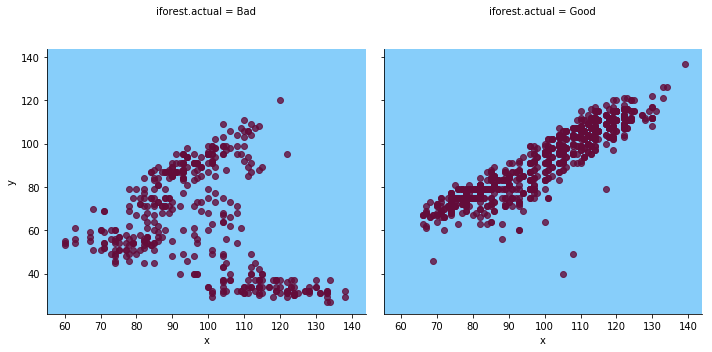

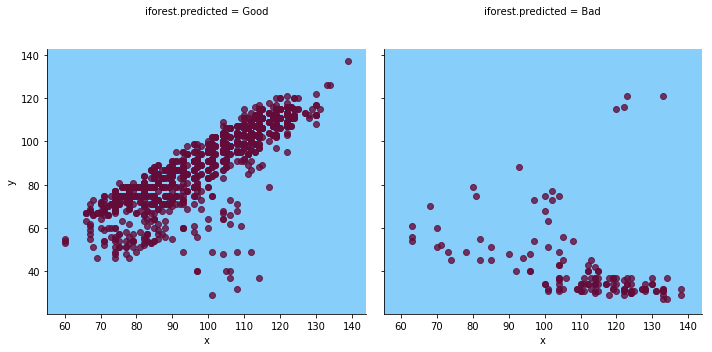

In [33]:
df1_iso, plot_x, plot_y, cols = plot_prep(data_splits,clf1_trained, 0, 1, "iforest")
plot_data(df1_iso, x=plot_x, y=plot_y, col=cols[0])
plot_data(df1_iso, x=plot_x, y=plot_y, col=cols[1])

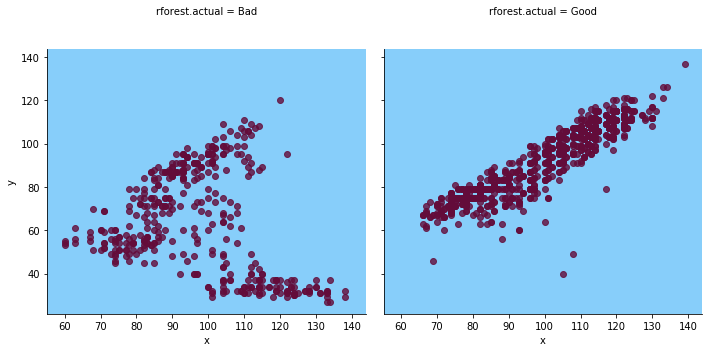

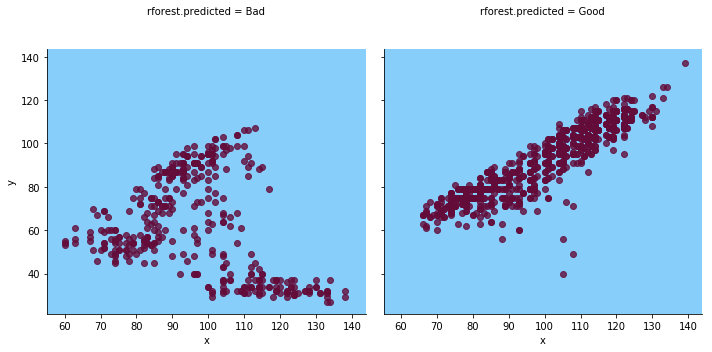

In [32]:
df1_rf, plot_x, plot_y, cols = plot_prep(data_splits,rfc1_trained, 0, 0, "rforest")
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df1_rf, x=plot_x, y=plot_y, col=cols[1])

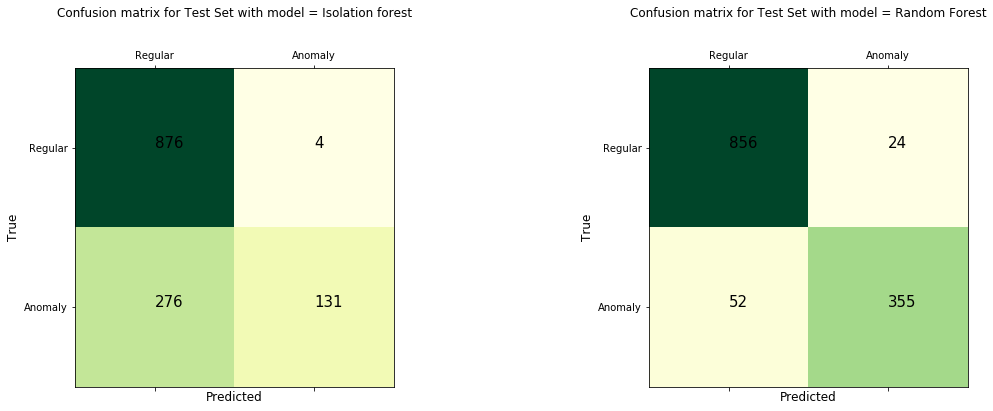

In [37]:
test1_iso, pred1_iso, labels1_iso = conf_prep(df1_iso, "iforest")
test1_rf, pred1_rf, labels1_ref = conf_prep(df1_rf, "rforest")
    
fig = plt.figure(figsize=(16,12))
conf_matrix(test1_iso, pred1_iso, fig, labels=labels1_iso, z=1 )
conf_matrix(test1_rf, pred1_rf, fig, labels= labels1_ref, model_name="Random Forest", z=2)
fig.subplots_adjust(wspace=0.8)
plt.show()

**Case - Dataset #2**<br/>
A very imbalanced dataset for ICU discharge of patients. A bad discharge is when the patient had to be readmitted within 90 days of discharge from the ICU. A very few cases of bad discharge are present in the dataset which indicates that such cases can simply be anomalies.

*Description: X = Multi-dimensional point data, y = labels (1 = outliers, 0 = inliers)*

In [41]:
'''Isolation and Random Forest on really bad dataset'''
path = 'resources/pacemed/'
df_icu = pd.read_csv(path+'cleaned.csv',index_col=None, sep=',')
df_icu['bad_discharge'] = df_icu['bad_discharge'].astype('int')
df_icu.head()


,primary_key,blood_pressure,respiration_rate,temperature,age,days_ICU,bad_discharge
0,0-2016-01-05,133.367285,3.331333,35.746152,35.0,2.0,0
1,1-2014-07-04,127.878761,5.333333,37.133845,77.0,2.0,0
2,10-2015-07-02,109.261078,5.775556,37.405126,50.0,3.0,0
3,100-2014-06-28,128.925084,6.390000,36.293589,41.0,1.0,0
4,1000-2014-11-30,118.448189,8.975610,37.572649,79.0,2.0,0


In [43]:
'''Initialize Models Here'''
clf2 = IsolationForest(behaviour='new', max_samples=100,
                          random_state=rng, contamination=0.1)
    
rfc2 = RandomForestClassifier(n_estimators=1000, random_state=rng, max_features=1.,
                                 class_weight='balanced')

features = range(1,df_icu.shape[1]-1)
data_splits, clf2_trained, rfc2_trained = model_fitting(df_icu, features, 'bad_discharge', 0.20, rng, clf2, rfc2)

Training Features Shape: (1119, 5)
Training Labels Shape: (1119,)
Testing Features Shape: (280, 5)
Testing Labels Shape: (280,)


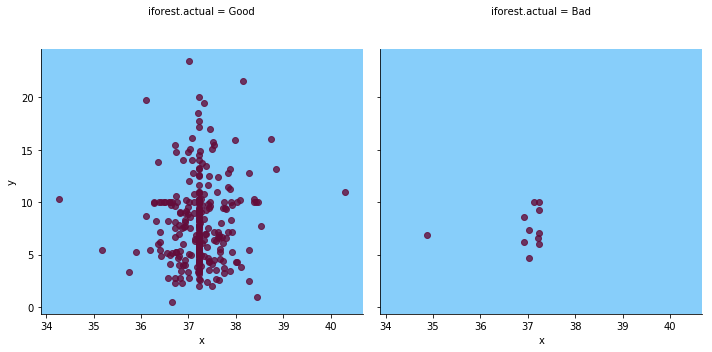

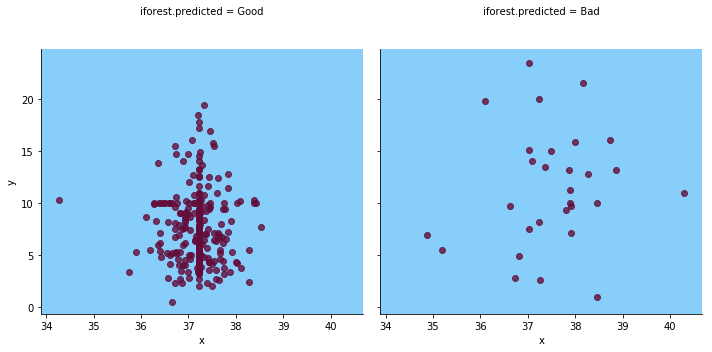

In [44]:
df2_iso, plot_x, plot_y, cols = plot_prep(data_splits,clf2_trained, 0, 1, "iforest")
plot_data(df2_iso, x=plot_x, y=plot_y, col=cols[0])
plot_data(df2_iso, x=plot_x, y=plot_y, col=cols[1])

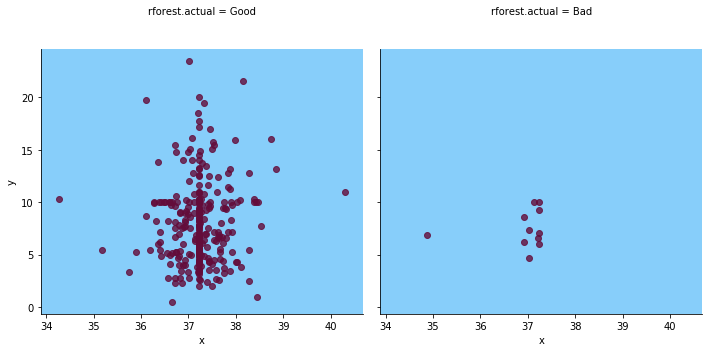

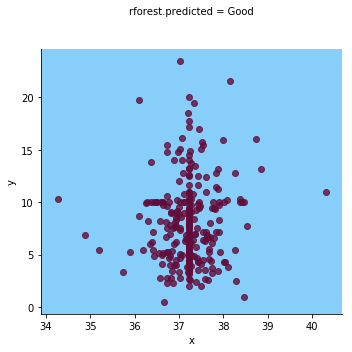

In [45]:
df2_rf, plot_x, plot_y, cols = plot_prep(data_splits,rfc2_trained, 0, 0, "rforest")
plot_data(df2_rf, x=plot_x, y=plot_y, col=cols[0])
plot_data(df2_rf, x=plot_x, y=plot_y, col=cols[1])

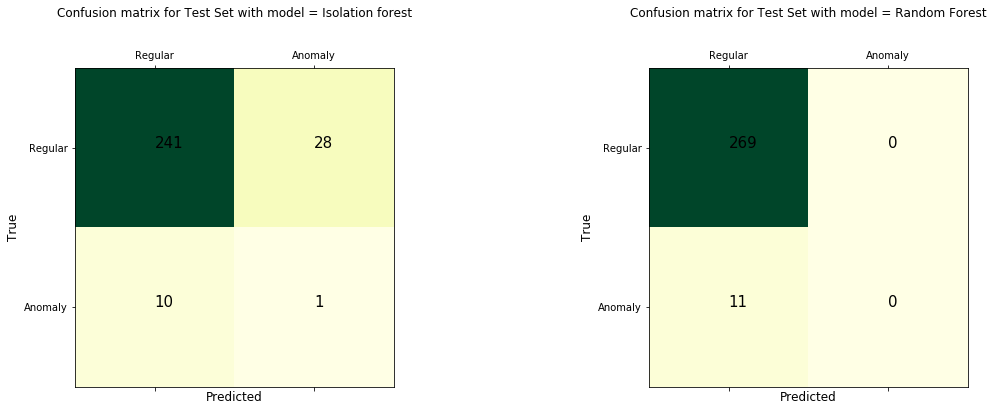

In [46]:
test2_iso, pred2_iso, labels2_iso = conf_prep(df2_iso, "iforest")
test2_rf, pred2_rf, labels2_ref = conf_prep(df2_rf, "rforest")
    
fig = plt.figure(figsize=(16,12))
conf_matrix(test2_iso, pred2_iso, fig, labels=labels2_iso, z=1 )
conf_matrix(test2_rf, pred2_rf, fig, labels= labels2_ref, model_name="Random Forest", z=2)
fig.subplots_adjust(wspace=0.8)
plt.show()